In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [7]:
image_dir = Path(r"C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHETIC")

In [8]:
filepaths = list(image_dir.glob(r'*/*.JPG'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [9]:
image_df

,Filepath,Label
0,C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHET...,brain_tumors.jpg
1,C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHET...,brain_tumors.jpg
2,C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHET...,brain_tumors.jpg
3,C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHET...,brain_tumors.jpg
4,C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHET...,brain_tumors.jpg
...,...,...
39995,C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHET...,kidney_tumors.jpg
39996,C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHET...,kidney_tumors.jpg
39997,C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHET...,kidney_tumors.jpg
39998,C:\Users\net pc\Desktop\THESIS PROJECT\SYNTHET...,kidney_tumors.jpg


In [10]:
train_df, test_df = train_test_split(image_df, train_size=0.80, shuffle=True, random_state=1)

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  horizontal_flip=True,
                                                                  width_shift_range=0.2,
                                                                  height_shift_range=0.2,
                                                                  validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [12]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                   x_col='Filepath',
                                                   y_col='Label',
                                                   target_size=(75, 75),
                                                   color_mode='rgb',
                                                   class_mode='binary',
                                                   batch_size=32,
                                                   shuffle=True,
                                                   seed=42,
                                                   subset='training')

val_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                 x_col='Filepath',
                                                 y_col='Label',
                                                 target_size=(75, 75),
                                                 color_mode='rgb',
                                                 class_mode='binary',
                                                 batch_size=32,
                                                 shuffle=True,
                                                 seed=42,
                                                 subset='validation')

test_images = test_generator.flow_from_dataframe(dataframe=test_df,
                                                 x_col='Filepath',
                                                 y_col='Label',
                                                 target_size=(75, 75),
                                                 color_mode='rgb',
                                                 class_mode='binary',
                                                 batch_size=32,
                                                 shuffle=False)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv3D, MaxPool3D , Dropout, Flatten
from tensorflow.keras.layers import Dropout

InceptionV3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(75, 75, 3))


InceptionV3.trainable = False



87910968/87910968 [==============================] - 11s 0us/step


In [14]:
model = keras.Sequential([
    InceptionV3,
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=1, activation='sigmoid'),
])

In [15]:
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [17]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.src.engine.functional.Functional object at 0x00000244AB38BA50> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x00000244AB3ABD50> True
<keras.src.layers.regularization.dropout.Dropout object at 0x00000244AB702E10> True
<keras.src.layers.core.dense.Dense object at 0x00000244AB700F90> True
<keras.src.layers.regularization.dropout.Dropout object at 0x00000244AB702F90> True
<keras.src.layers.core.dense.Dense object at 0x00000244AB6FC350> True
<keras.src.layers.regularization.dropout.Dropout object at 0x00000244AB718450> True
<keras.src.layers.core.dense.Dense object at 0x00000244A7658210> True


In [18]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/50


800/800 [==============================] - 339s 401ms/step - loss: 0.1893 - accuracy: 0.9239 - val_loss: 0.0499 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 2/50
800/800 [==============================] - 317s 396ms/step - loss: 0.0966 - accuracy: 0.9655 - val_loss: 0.0376 - val_accuracy: 0.9870 - lr: 0.0010
Epoch 3/50
800/800 [==============================] - 317s 397ms/step - loss: 0.0797 - accuracy: 0.9723 - val_loss: 0.0374 - val_accuracy: 0.9884 - lr: 0.0010
Epoch 4/50
800/800 [==============================] - 321s 402ms/step - loss: 0.0709 - accuracy: 0.9751 - val_loss: 0.0316 - val_accuracy: 0.9903 - lr: 0.0010
Epoch 5/50
800/800 [==============================] - 314s 392ms/step - loss: 0.0665 - accuracy: 0.9762 - val_loss: 0.0314 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 6/50
800/800 [==============================] - 317s 396ms/step - loss: 0.0605 - accuracy: 0.9790 - val_loss: 0.0231 - val_accuracy: 0.9930 - lr: 0.0010
Epoch 7/50
800/800 [========================

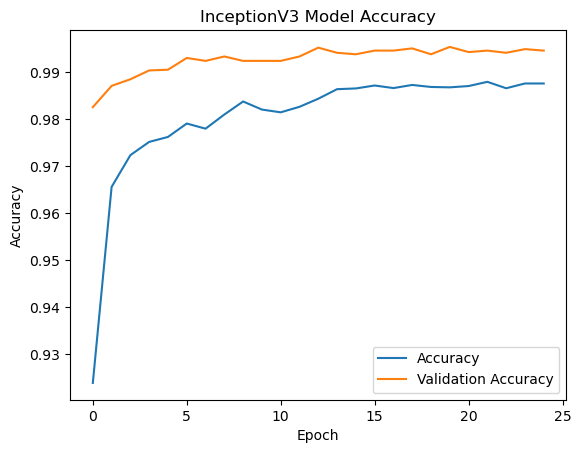

In [19]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(14, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('InceptionV3 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Validation Accuracy', 'loss', 'Validation Loss'])
plt.show()

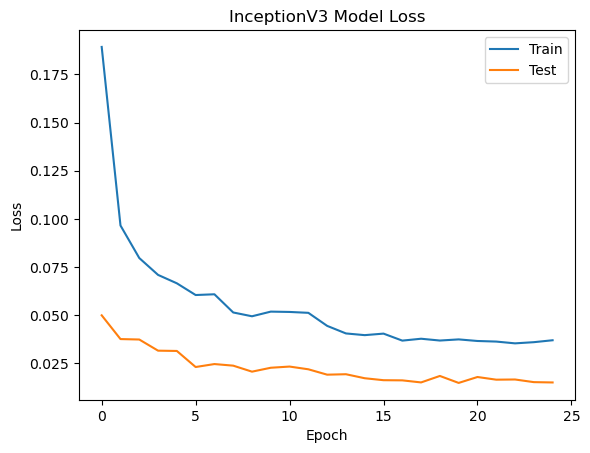

In [20]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(14, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('InceptionV3 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [21]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.01083
Test Accuracy: 99.66%


250/250 [==============================] - 36s 133ms/step


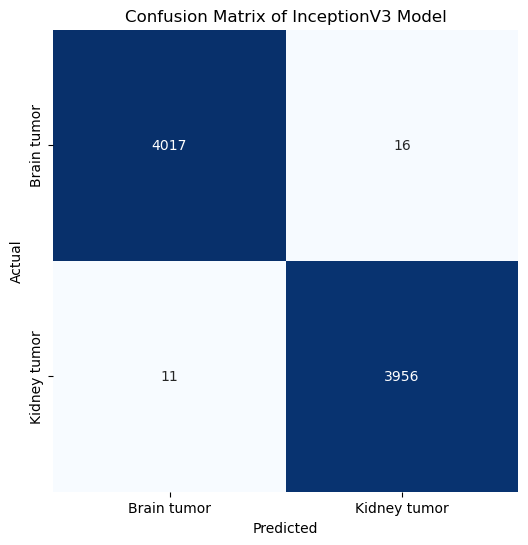

Classification Report:
----------------------
               precision    recall  f1-score   support

 Brain tumor       1.00      1.00      1.00      4033
Kidney tumor       1.00      1.00      1.00      3967

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [22]:
predictions = (model.predict(test_images) >= 0.5).astype(int)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["Brain tumor", "Kidney tumor"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["Brain tumor", "Kidney tumor"])
plt.yticks(ticks=[0.5, 1.5], labels=["Brain tumor", "Kidney tumor"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of InceptionV3 Model")
plt.show()

print("Classification Report:\n----------------------\n", clr)

250/250 [==============================] - 34s 135ms/step
AUC ROC: 0.99989


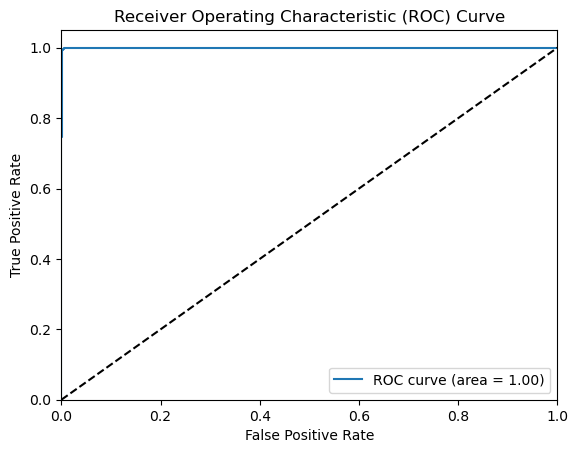

In [23]:
# Obtain predicted probabilities
from sklearn.metrics import roc_auc_score, roc_curve

predicted_probabilities = model.predict(test_images)

# Compute AUC ROC
auc_roc = roc_auc_score(test_images.labels, predicted_probabilities)

print("AUC ROC: {:.5f}".format(auc_roc))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_images.labels, predicted_probabilities)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [19]:
# save the model to a file
model.save('InceptionV3-ACC vs Kidney tumor .h5')